<a href="https://colab.research.google.com/github/zrosen3/Colombian-peso-counterfeit-detection/blob/main/Code/hybrid_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [1]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
%cd /content/Colombian-peso-counterfeit-detection/Code       

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 42278, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 42278 (delta 72), reused 25 (delta 18), pack-reused 42174
Receiving objects: 100% (42278/42278), 883.75 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (1231/1231), done.
Updating files: 100% (103997/103997), done.
/content/Colombian-peso-counterfeit-detection/Code


In [2]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import cv2
from PIL import Image
import seaborn as sns
import common_functions as cf
import xgboost as xgb



#Load in data

In [3]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=16)


Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


## Create ensemble of CNNs

Create ensemble model

In [4]:
#Initialize keras session
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
#ANN
ann = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(480, 640, 3)),
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(
                  units = 13,
                activation = "softmax"
          )])
ann.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

ann.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
  
#Model 2 = Custom CNN
cnn = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(len(class_names))])
cnn.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
'''
#Model 3 = CNN-LTSM
cnn_ltsm = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(len(class_names)) 
])

cnn_ltsm.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn_ltsm.fit(
train_ds,
validation_data=validation_ds,
epochs=5)

'''

Epoch 1/5
1560/1560 [==============================] - 53s 30ms/step - loss: 73.4240 - accuracy: 0.3919 - val_loss: 10.3785 - val_accuracy: 0.5755
Epoch 2/5
1560/1560 [==============================] - 47s 30ms/step - loss: 18.8129 - accuracy: 0.5048 - val_loss: 17.7950 - val_accuracy: 0.4244
Epoch 3/5
1560/1560 [==============================] - 47s 30ms/step - loss: 16.1369 - accuracy: 0.5533 - val_loss: 9.9201 - val_accuracy: 0.5983
Epoch 4/5
1560/1560 [==============================] - 47s 30ms/step - loss: 6.5225 - accuracy: 0.6261 - val_loss: 5.9934 - val_accuracy: 0.6191
Epoch 5/5
1560/1560 [==============================] - 47s 30ms/step - loss: 5.0558 - accuracy: 0.6357 - val_loss: 5.9087 - val_accuracy: 0.6398
Epoch 1/5
1560/1560 [==============================] - 58s 33ms/step - loss: 2.9334 - accuracy: 0.0922 - val_loss: 2.5649 - val_accuracy: 0.0893
Epoch 2/5
1560/1560 [==============================] - 51s 33ms/step - loss: 2.5649 - accuracy: 0.0907 - val_loss: 2.5649 - v

ValueError: ignored

Create ensemble model

In [5]:
models = [ann, cnn]
input_layer = tf.keras.layers.Input(shape=(480, 640, 3))  
outputs = []
for i,model in enumerate(models):
    model._name = str(i)
    output = model(input_layer)
    outputs.append(output)
averaged_outputs = tf.reduce_mean(outputs, axis = 0)
output_layer = tf.keras.layers.Dense(13, activation='softmax')(averaged_outputs)  
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Fit ensemble model



In [6]:
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = ensemble_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5)

Epoch 1/5
1560/1560 [==============================] - 66s 40ms/step - loss: 1.2702 - accuracy: 0.7060 - val_loss: 0.1848 - val_accuracy: 0.9469
Epoch 2/5
1560/1560 [==============================] - 62s 40ms/step - loss: 0.1067 - accuracy: 0.9671 - val_loss: 0.1419 - val_accuracy: 0.9582
Epoch 3/5
1560/1560 [==============================] - 63s 40ms/step - loss: 0.0638 - accuracy: 0.9806 - val_loss: 0.1520 - val_accuracy: 0.9611
Epoch 4/5
1560/1560 [==============================] - 63s 40ms/step - loss: 0.0461 - accuracy: 0.9863 - val_loss: 0.1643 - val_accuracy: 0.9575
Epoch 5/5
1560/1560 [==============================] - 63s 40ms/step - loss: 0.0401 - accuracy: 0.9877 - val_loss: 0.2153 - val_accuracy: 0.9502


## Inspect model performance

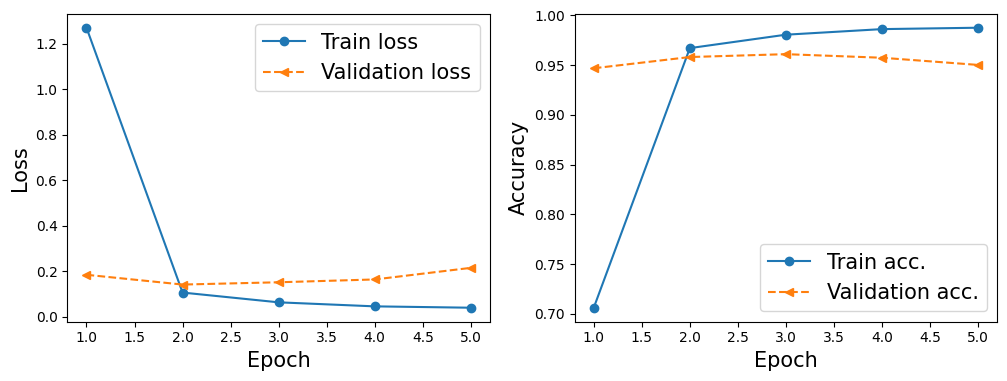

520/520 - 11s - loss: 0.2347 - accuracy: 0.9494 - 11s/epoch - 21ms/step
Test loss: 0.23465576767921448 | Test accuracy: 0.9493990540504456


(0.9876592755317688, 0.9502403736114502, 0.9493990540504456)

In [7]:
cf.EvaluateModel(ensemble_model, test_ds, history)


Macro averaged precision score: 0.9493990384615386
Macro averaged recall score: 0.9524178502592009
Macro averaged F1 score: 0.949858309368098


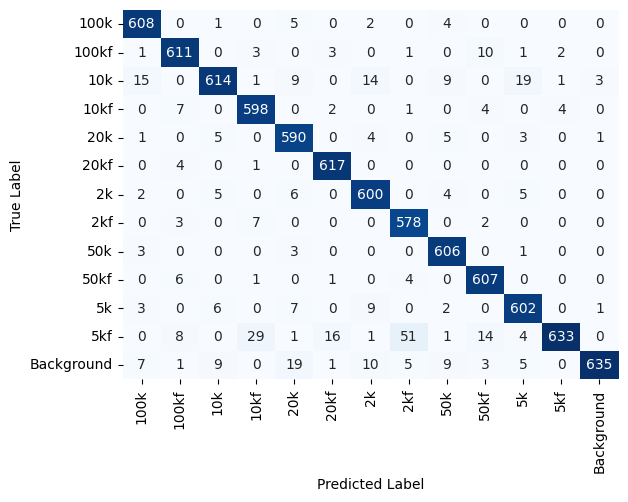

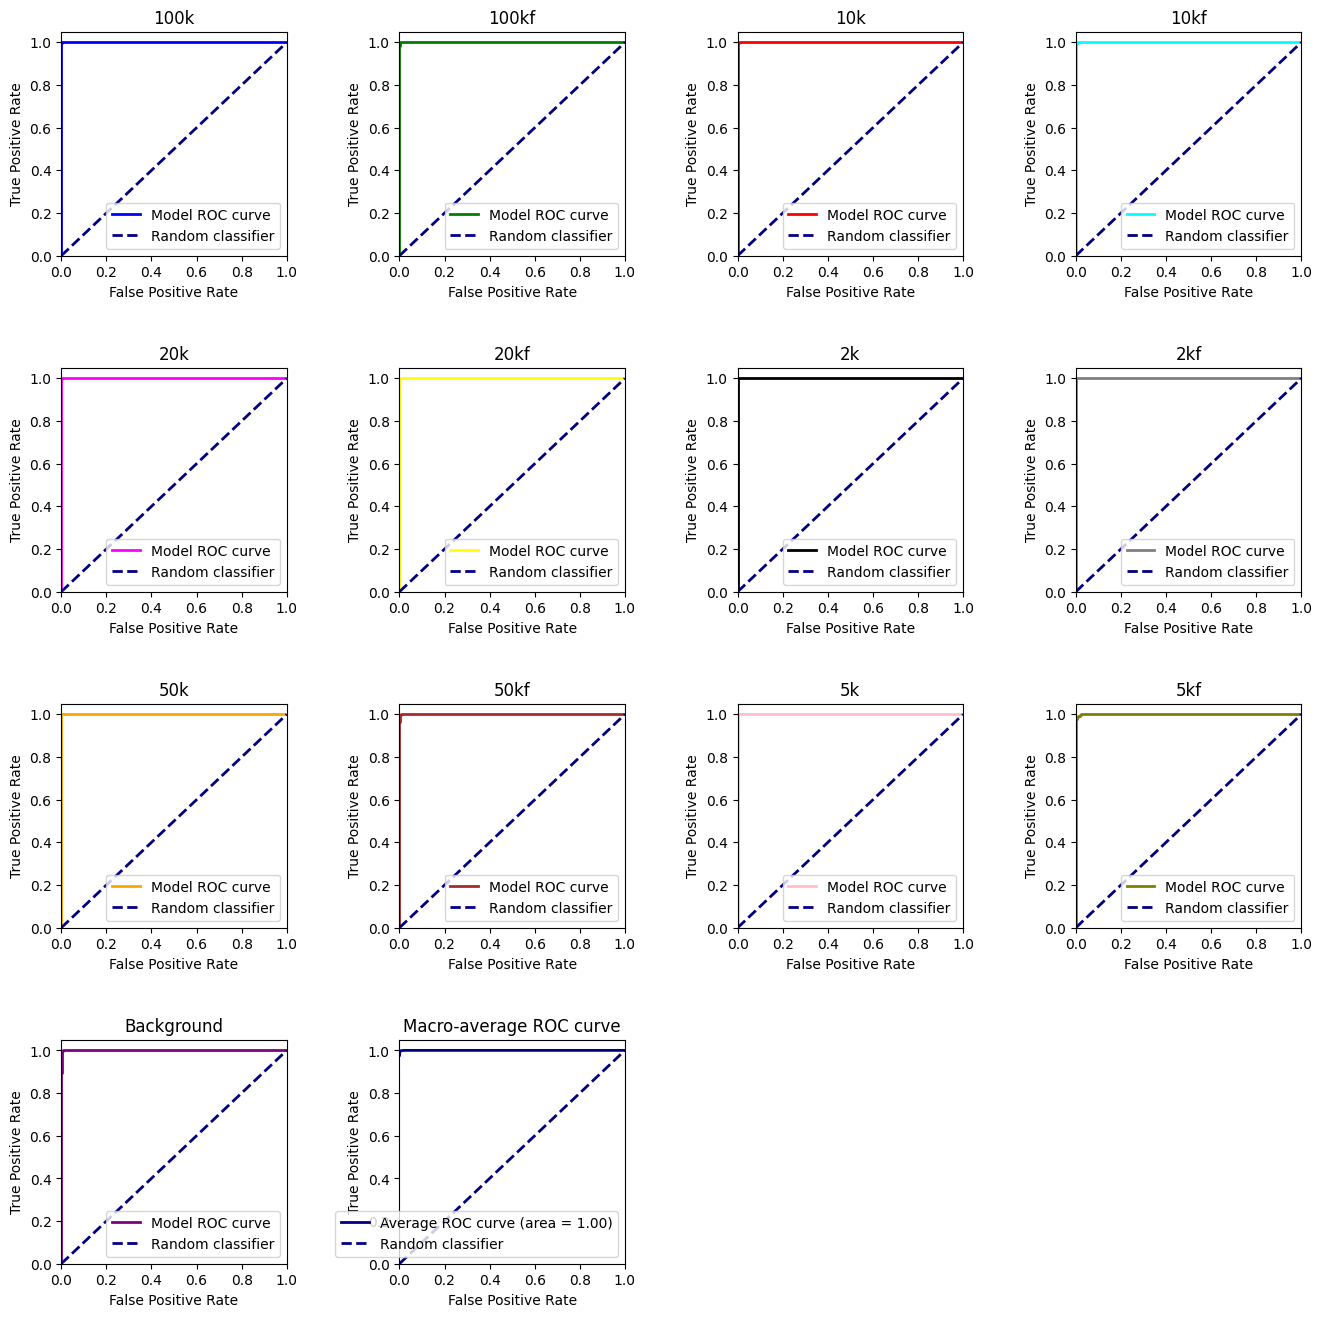

In [8]:
cf.precision_recall_metrics(ensemble_model, test_ds, class_names)